<a href="https://colab.research.google.com/github/Dp20032/Neuromatch_BrainCancer/blob/Dhiren/code/VGG19_Classifier_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Package Imports
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.utils import make_grid
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset
import torchvision.models as models
from torchsummary import summary

import os
from google.colab import files
from PIL import Image
import subprocess

In [2]:
# @title Data Loading
print('Upload kaggle.json account information to download the dataset:')
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip -q brain-tumor-mri-dataset.zip

Upload kaggle.json account information to download the dataset:


Saving kaggle.json to kaggle.json
 95% 141M/149M [00:00<00:00, 187MB/s]
100% 149M/149M [00:00<00:00, 182MB/s]


In [3]:
# @title Download and processing Zenodo data - unneeded, data represented in original dataset
#!wget https://zenodo.org/record/7047164/files/adnoma.zip
#!wget https://zenodo.org/record/7047164/files/Gliomas.zip
#!wget https://zenodo.org/record/7047164/files/Meningioma.zip

def grab_format_zenodo(type='adnoma', size=(256,256)):
  url = f'https://zenodo.org/record/7047164/files/{type}.zip'
  print(f'Downloading {type}')
  subprocess.call(['wget', '-v', url])
  print(f'{type} acquired, unzipping...')
  subprocess.call(['unzip', '-q', f'{type}.zip'])
  files = os.listdir(f'./{type}')
  print(f'Unzipping {type} completed [{len(files)} samples extracted], beginning conversion...')
  size=(256,256)
  for i in files:
    im = Image.open(f'./{type}/{i}')
    i, _ = i.split('.')
    new = im.resize(size)
    if not os.path.isdir(f'./{type}_png'):
      os.mkdir(f'./{type}_png')
    new.save(f'./{type}_png/{i}.png', 'png')

# for i in ['adnoma', 'Gliomas', 'Meningioma']:
#   grab_format_zenodo(type=i)


In [4]:
classes = os.listdir('./Training/')

0 tensor([1, 3, 3, 1, 0, 1, 2, 3, 1, 2])


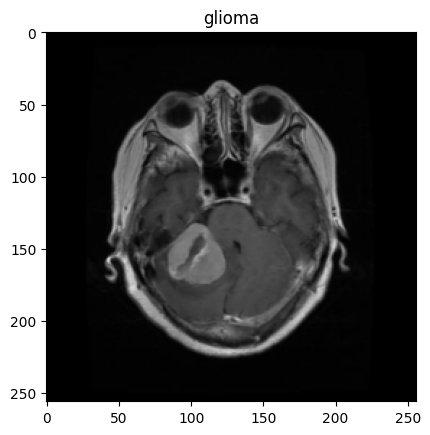

In [5]:
# @title Dataset Generation
#TODO - Verify labels correspond to classes
data_transf = transforms.Compose([
transforms.Resize((256, 256)),
transforms.ToTensor()])
import matplotlib.pyplot as plt
TrainingDataset = ImageFolder(root='./Training/', transform=data_transf)#, transform=torchvision.models.VGG19_Weights.IMAGENET1K_V1.transforms)
TrainingLoader = DataLoader(TrainingDataset, batch_size=10, shuffle=True)
for batch_number , (images, labels) in enumerate(TrainingLoader):
  print(batch_number, labels)
  plt.imshow(torch.moveaxis(images[0], 0, -1))
  plt.title(classes[labels[0]])
  plt.show()
  break

In [9]:
device= device = torch.device("cuda")

Epoch 1, Batch 10, Loss: 2.733
Epoch 1, Batch 20, Loss: 2.385
Epoch 1, Batch 30, Loss: 1.058
Epoch 1, Batch 40, Loss: 1.489
Epoch 1, Batch 50, Loss: 1.029
Epoch 1, Batch 60, Loss: 0.941
Epoch 1, Batch 70, Loss: 0.961
Epoch 1, Batch 80, Loss: 0.996
Epoch 1, Batch 90, Loss: 1.095
Epoch 1, Batch 100, Loss: 0.684
Epoch 1, Batch 110, Loss: 0.892
Epoch 1, Batch 120, Loss: 1.448
Epoch 1, Batch 130, Loss: 0.902
Epoch 1, Batch 140, Loss: 0.836
Epoch 1, Batch 150, Loss: 1.025
Epoch 1, Batch 160, Loss: 1.323
Epoch 1, Batch 170, Loss: 1.488
Epoch 1, Batch 180, Loss: 1.499
Epoch 1, Batch 190, Loss: 0.868
Epoch 1, Batch 200, Loss: 0.861
Epoch 1, Batch 210, Loss: 1.335
Epoch 1, Batch 220, Loss: 0.597
Epoch 1, Batch 230, Loss: 1.616
Epoch 1, Batch 240, Loss: 1.414
Epoch 1, Batch 250, Loss: 1.027
Epoch 1, Batch 260, Loss: 0.783
Epoch 1, Batch 270, Loss: 0.436
Epoch 1, Batch 280, Loss: 0.944
Epoch 1, Batch 290, Loss: 0.951
Epoch 1, Batch 300, Loss: 1.195
Epoch 1, Batch 310, Loss: 0.859
Epoch 1, Batch 32

ValueError: ignored

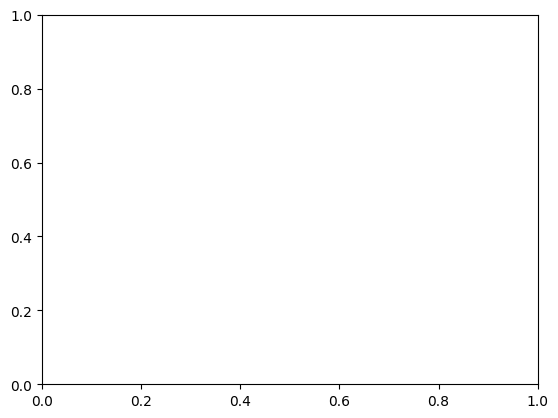

In [14]:
Classifier = models.vgg19(weights='DEFAULT')

for param in Classifier.features.parameters():
    param.requires_grad = False


#Replace the classifying linear network with one with custom number of output classes
num_features = Classifier.classifier[-1].in_features
Classifier.classifier[-1] = nn.Linear(num_features, 4)

Classifier = Classifier.to(device)


loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(Classifier.parameters(), lr=0.001)


num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    epoch_loss= []
    for batch_number, (images, labels) in enumerate(TrainingLoader):

       images = images.to(device)
       labels = labels.to(device)

       optimizer.zero_grad()
       outputs = Classifier(images)
       loss = loss_function(outputs, labels)

       loss.backward()
       optimizer.step()

       running_loss += loss.item()
       if batch_number % 100 == 9:
          print(f'Epoch {epoch + 1}, Batch {batch_number + 1}, Loss: {running_loss / 10:.3f}')
          epoch_loss.append(running_loss/len(TrainingLoader))
          running_loss = 0.0

print('Finished Training')
plt.plot(num_epochs, epoch_loss)

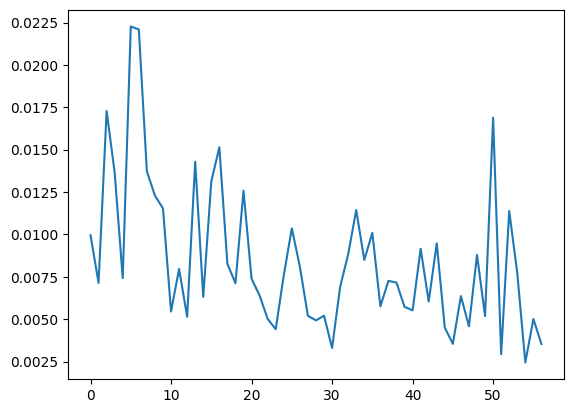

In [16]:
plt.plot(range(57), epoch_loss)